## Compute weight distances with multiple principal components

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from numpy import linalg as LA
from importlib import reload
from numpy import linalg as LA
from scipy.stats import ks_2samp

import re
from pyaldata import *
from rutils import *
from distance_methods import *
import distance_methods
from tqdm import tqdm as pbar
reload(distance_methods)
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact

'''
Plotting aesthetics
'''
sns.set_style('white')
cmap = sns.light_palette(color='#02703a', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)
cs = ['#732514', '#FEB312', '#233A6A', '#545340', '#4E81AF', '#183D51', '#3985BA', '#c92039', '#656a75', '#F7B969']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth':2, })

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

In [2]:
dist_cmap = sns.light_palette('#092d68', 11)

## 0 Load data

To be able to say something meaningful about data coming from different sessions, we will have to ensure that they are similar. This is a non-trivial problem due to the _spatial correlation_ and _autocorrelation_ structures. We select a session below.

In [3]:
'''
Note: VR sessions have typically more neurons than CF sessions
'''

sessions_vr = [
 'Chewie_CO_VR_2016-09-09.mat', # File Matt used to generate initial figures
 'Chewie_CO_VR_2016-09-12.mat',
 'Chewie_CO_VR_2016-09-14.mat',
 'Chewie_CO_VR_2016-10-06.mat',
 'Mihili_CO_VR_2014-03-03.mat',
 'Mihili_CO_VR_2014-03-04.mat',
 'Mihili_CO_VR_2014-03-06.mat',
]

sessions_cf = [
    'Chewie_CO_FF_2016-09-15.mat',
    'Chewie_CO_FF_2016-09-21.mat',
    'Chewie_CO_FF_2016-10-05.mat',
    'Chewie_CO_FF_2016-10-07.mat',
    'Mihili_CO_FF_2014-02-03.mat',
    'Mihili_CO_FF_2014-02-17.mat',
    'Mihili_CO_FF_2014-02-18.mat',
    'Mihili_CO_FF_2014-03-07.mat'
]

In [4]:
'''
Choose a session
'''
session = sessions_vr[3]
print('------------------------------')
print(f'Selected session: {session}')
print('------------------------------')

# Data path
df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)

# Get the date of the session and monkey name for plotting later
date = '-'.join(re.findall('[0-9]+', session))
monkey = session[:6]

# Read in cmp file and get electrode map
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

------------------------------
Selected session: Chewie_CO_VR_2016-10-06.mat
------------------------------


## 1 Preprocess

### 1.1 Preprocess spiking data 

First, we preprocess the trial data. Note that changing the parameters here will influence the results. 

In [5]:
warnings.filterwarnings('ignore')

# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

# Sqrt transform neurons
td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

# Select only baseline (BL) trials
td = td.loc[td['epoch'] == 'BL']

print(f'Number of neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]} \
        => After processing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]} (M1: {td.M1_spikes[0].shape[1]}, PMd: {td.PMd_spikes[0].shape[1]})')

Number of neurons before processing: 255         => After processing: 255 (M1: 63, PMd: 192)


### 1.2 Inspect activity distribution and shuffle data to generate random matrix (control) 

Here, we do the following

- Plot the distribution of the firing rates of the neurons to ensure this is constant across sessions
- Shuffle the empirical data $\mathbf{X}_{emp}$ to create a random data matrix $\mathbf{X}_{rand}$, this can be used as a control
    - We perform dimensionality reduction on both matrices.
    
- There are different ways to generate a random data matrix 
    1. Iterate over the rows and columns of $\mathbf{X}_{emp}$ and pick a random value for each element in $\mathbf{X}_{rand}$ [current]
    
    2. Shuffle the rows only: break neuron correlations

    The spatial correlation structure is likely important in this data set. To explore to what extent this is the case, it makes sense to benchmark against a similar data set that has     no spatial dependence. This can be attained by randomizing the order of the rows. Note that it could be that you do not see any difference as PCA may result in the same outcomes  
    (not sure if that is the case). One possible reason for this could be that the underlying 'components' of the data are not changed by shuffling the data.
    
    3. Shuffle the columns only: break time correlations
    
    What can be done for the spatial relationships can also be done for the time dependence. Hence, you would have to shuffle the columns. I do expect a clear difference here as PCA   
    analysis should be different.

In [6]:
# This is the trial-concatenated data on which we will perform dimensionality reduction
X_emp = np.concatenate(td['both_rates'].values, axis=0)

X_emp.shape # (timepoints x neurons)

(27904, 255)

In [7]:
# Shuffle the data 
X_gen = np.zeros_like(X_emp)

for i in pbar(range(X_emp.shape[0])):
    for j in range(X_emp.shape[1]):
        k = np.random.choice(X_emp.shape[0])
        l = np.random.choice(X_emp.shape[1])
        X_gen[i, j] = X_emp[k, l]

100%|██████████| 27904/27904 [03:52<00:00, 120.01it/s]


In [8]:
# Save shuffled data because it takes a while
#np.save('X_gen_Ch20160909', X_gen)

In [9]:
# load generated matrix for convenience 
#X_gen = np.load('X_gen_Ch20160909.npy')

In [10]:
# X_gen = X_emp.copy()

# # Shuffle rows (neurons) only 
# rng = np.random.default_rng()
# rng.shuffle(X_gen, axis=0)

In [8]:
# Sanity check: are the elements shuffled properly?
X_emp[0, :20]

array([10.372, 15.774,  2.629,  8.636, 12.354, 20.963, 10.269, 13.144,
        6.295,  7.639,  2.629,  7.743,  8.636,  3.718,  2.629,  7.743,
       11.815, 15.774, 10.269,  7.743])

In [9]:
X_gen[0, :20]

array([ 2.629,  0.   , 10.804,  0.   ,  0.   , 22.726,  3.522,  0.   ,
        8.031,  5.402,  8.031,  0.   ,  2.629,  0.   ,  2.629,  0.   ,
        5.402,  0.   ,  2.629,  0.   ])

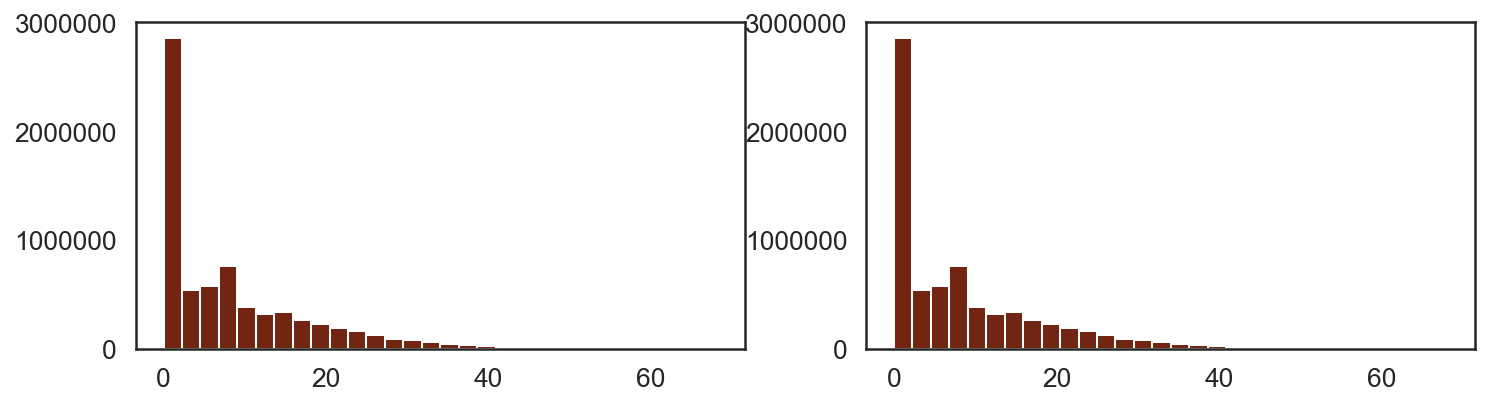

In [10]:
# Sanity check: are the distributions of firing rates still the same?
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Yep!
axs[0].hist(X_gen.flatten(), bins=30);
axs[1].hist(X_emp.flatten(), bins=30);
# Note: this is not normally distributed

## 2 Perform PCA on data $\mathbf{X}_{emp}$ (both M1 & PMd) and the random matrix $\mathbf{X}_{rand}$

In [12]:
# Get the full PC matrix
all_neuron_dims = td.both_rates[0].shape[1]

# Perform PCA on the trial concatenated (by timepoints) trialdata
td, model_m1pmd = tools.dim_reduce(td, PCA(n_components = all_neuron_dims), 'both_rates', 'both_pca', return_model=True)

# Perform PCA on the shuffled data matrix
model_gen = PCA(n_components = all_neuron_dims)
model_gen.fit(X_gen);

# Transpose to get (neurons x PCs)
m1pmd_pcs = model_m1pmd.components_.T
gen_pcs = model_gen.components_.T

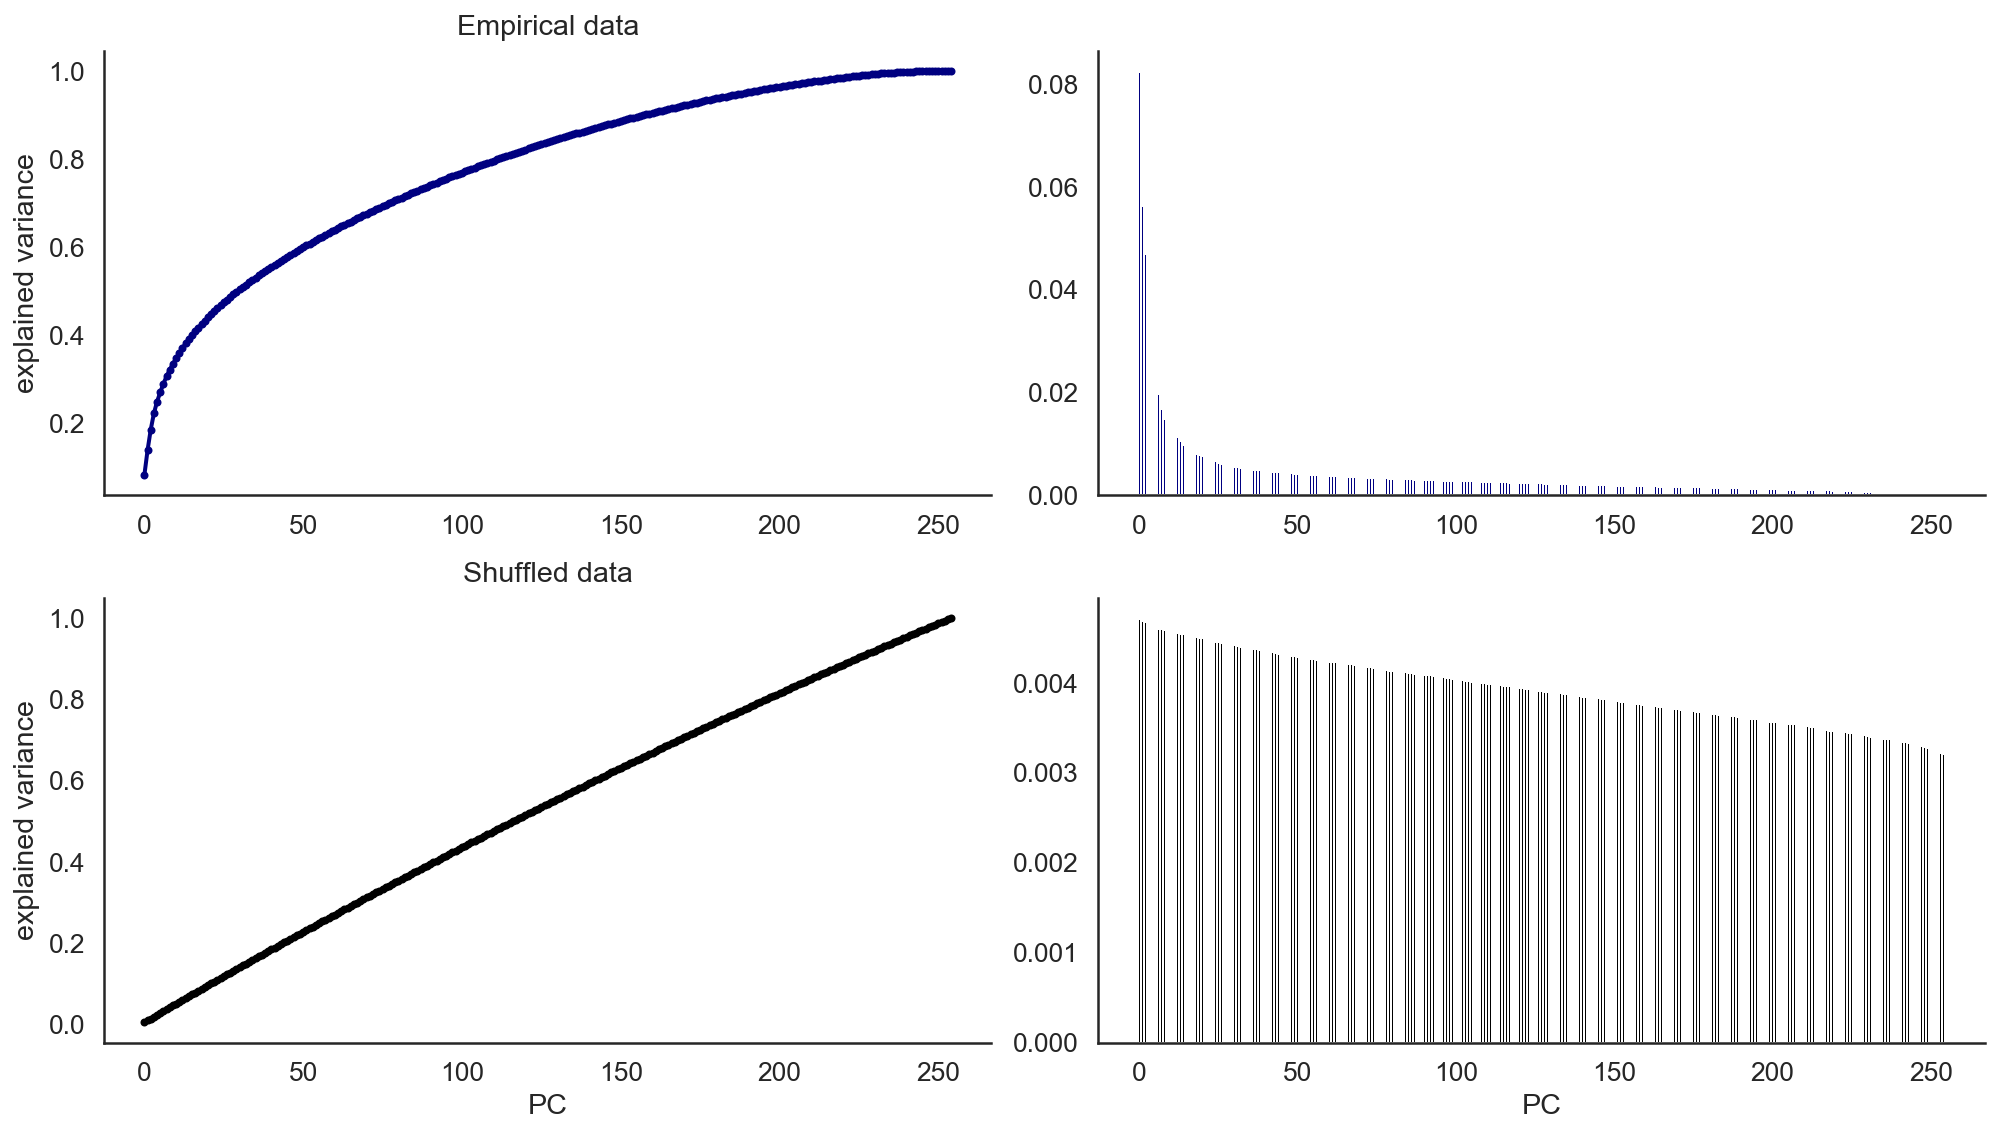

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].set_title('Empirical data', y=1.01)
axs[0, 0].plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-', color='navy')
axs[0, 0].set_ylabel('explained variance')

axs[0, 1].bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_, alpha=1, align='center', color='navy')

axs[1, 0].set_title('Shuffled data', y=1.01)
axs[1, 0].plot(model_gen.explained_variance_ratio_.cumsum(), '.-', color='k')
axs[1, 0].set_xlabel('PC')
axs[1, 0].set_ylabel('explained variance')

axs[1, 1].bar(range(len(model_gen.explained_variance_ratio_)), model_gen.explained_variance_ratio_, alpha=1, align='center', color='k')
axs[1, 1].set_xlabel('PC')

fig.tight_layout()
sns.despine()

### Compute pairwise pearson correlation with _r_ pcs 

- Compute pearson correlation between the rows 
- Resulting matrix shows how similar the neural patterns of activity are between neurons
    - _note_: can also represent this as 1 - correlation (dissimilarity)

In [14]:
'''
Get the spatial distances in N x N matrix
'''

m1_ug = td['M1_unit_guide'][0]
pmd_ug = td['PMd_unit_guide'][0]

n_m1 = m1_ug.shape[0]
n_pmd = pmd_ug.shape[0]
N = m1_ug.shape[0] + pmd_ug.shape[0]
SD = np.zeros((N, N))

for i in range(N): 
    for j in range(N):

        if i < n_m1 and j < n_m1: # If both neurons are on the M1 arr (within)
            
            #print(f'{i, j} (within m1)')
            elec_i, elec_j = m1_ug[i, 0], m1_ug[j, 0] # Locate neuron on electrode
            loc_i, loc_j = np.array(np.where(m1_emap == elec_i)), np.array(np.where(m1_emap == elec_j)) 
            # Compute spatial distance between neurons
            SD[i, j] = LA.norm(loc_i - loc_j)

        elif i >= n_m1 and j >= n_m1: # If both neurons are on the PMD arr (within)
            k = i - n_m1
            p = j - n_m1

            # Locate neuron on electrode
            elec_i, elec_j = pmd_ug[k, 0], pmd_ug[p, 0] 
            loc_i, loc_j = np.array(np.where(pmd_emap == elec_i)), np.array(np.where(pmd_emap == elec_j)) 
            # Compute spatial distance between neurons
            SD[i, j] = LA.norm(loc_i - loc_j)

        else: # Between (Spatial distance unknown)
            SD[i, j] = np.nan

In [19]:
SD_cats = np.zeros((N, N))

se_mask = np.where(abs(SD) < 0.001)
sa_mask = np.where(abs(SD) != 0)
oa_mask = list(map(tuple, np.where(np.isnan(SD))))

SD_cats[se_mask] = 0
SD_cats[sa_mask] = 1
SD_cats[oa_mask] = 2

In [20]:
'''
Compute correlations between pairwise neurons (rows with r elements)
'''

r_range = np.arange(3, 13) # Choose the number of PCs 
N = gen_pcs.shape[0] # Number of neurons

R_emp_arr, R_gen_arr = [], []

for r in pbar(r_range):
    
    gen_pcs_sub = gen_pcs[:, :r]
    emp_pcs_sub = m1pmd_pcs[:, :r]

    R_gen, R_emp = np.zeros((N, N)), np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            R_emp[i, j], _ = stats.pearsonr(emp_pcs_sub[i, :], emp_pcs_sub[j, :])
            R_gen[i, j], _ = stats.pearsonr(gen_pcs_sub[i, :], gen_pcs_sub[j, :])
            
    R_gen_arr.append(R_gen), R_emp_arr.append(R_emp)

R_gen_arr, R_emp_arr = np.array(R_gen_arr), np.array(R_emp_arr)

100%|██████████| 10/10 [03:06<00:00, 18.60s/it]


In [21]:
import rutils
reload(rutils)
from rutils import *

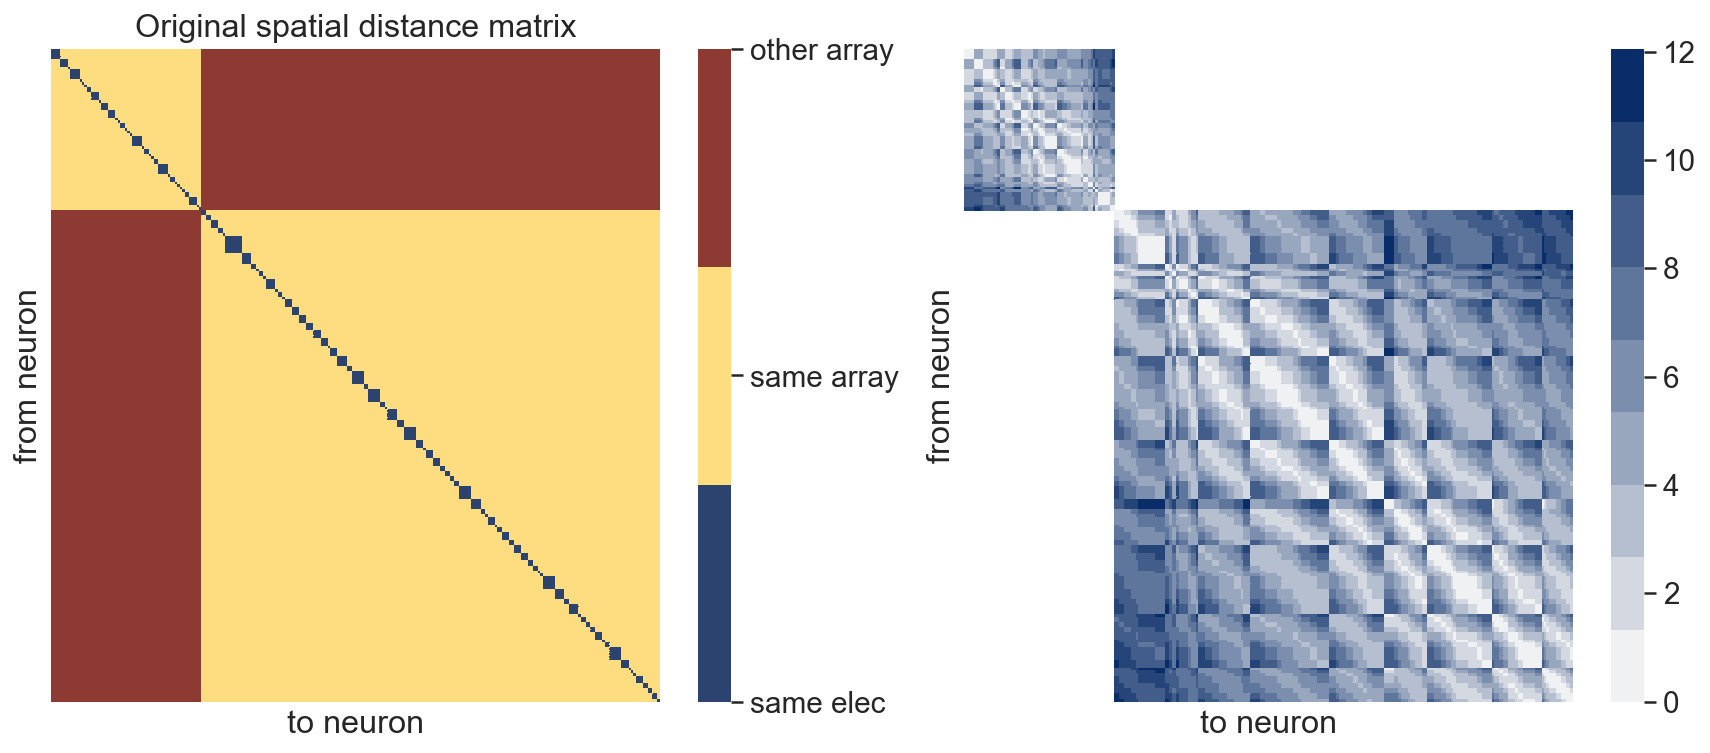

In [22]:
# Reorder spatial distances
fig, axs = plt.subplots(1, 2, figsize=(15, 6))                        

dis_cmap = LinearSegmentedColormap.from_list('Custom', ('#2c4370', '#fddd7f', '#8d3b32'), 3)

hm = sns.heatmap(SD_cats, cmap=dis_cmap, xticklabels=False, yticklabels=False, ax=axs[0])

colorbar = hm.collections[0].colorbar
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(['same elec', 'same array', 'other array'])
axs[0].set_xlabel('to neuron')
axs[0].set_ylabel('from neuron')
axs[0].set_title('Original spatial distance matrix')

sns.heatmap(SD, cmap=dist_cmap, xticklabels=False, yticklabels=False, ax=axs[1]);
axs[1].set_xlabel('to neuron')
axs[1].set_ylabel('from neuron');

## Cluster

[Matlab function Matt used](https://nl.mathworks.com/help/stats/cluster.html?s_tid=doc_ta)

Choose a [clustering method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)

In [40]:
i=9

print(f'Using the first {r_range[i]} PCs')

Using the first 12 PCs


### Use agglomerative clustering on data

In [45]:
# clustergrid = sns.clustermap(R_emp_arr[i], cmap='bwr', method='average')

# # Reordered neuron indices according to clustered map
# reordered_ids = clustergrid.dendrogram_row.reordered_ind

# # Reorder spatial distances
# fig, axs = plt.subplots(2, 1, figsize=(7, 14))                        

# dis_cmap = LinearSegmentedColormap.from_list('Custom', ('#2c4370', '#fddd7f', '#8d3b32'), 3)

# hm = sns.heatmap(SD_cats[reordered_ids], cmap=dis_cmap, xticklabels=False, yticklabels=False, ax=axs[0])

# colorbar = hm.collections[0].colorbar
# colorbar.set_ticks([0, 1, 2])
# colorbar.set_ticklabels(['same elec', 'same array', 'other array'])
# axs[0].set_xlabel('to neuron')
# axs[0].set_ylabel('from neuron');

# sns.heatmap(SD[reordered_ids], cmap=dist_cmap, xticklabels=False, yticklabels=False, ax=axs[1]);
# axs[1].set_xlabel('to neuron')
# axs[1].set_ylabel('from neuron');

### Do the same for the shuffled data

In [46]:
# clustergrid = sns.clustermap(R_gen_arr[i], cmap='bwr', method='average')

# # Reordered neuron indices
# reordered_ids = clustergrid.dendrogram_row.reordered_ind

# # Reorder spatial distances
# fig, axs = plt.subplots(2, 1, figsize=(7, 14))                        

# dis_cmap = LinearSegmentedColormap.from_list('Custom', ('#2c4370', '#fddd7f', '#8d3b32'), 3)

# hm = sns.heatmap(SD_cats[reordered_ids], cmap=dis_cmap, xticklabels=False, yticklabels=False, ax=axs[0])

# colorbar = hm.collections[0].colorbar
# colorbar.set_ticks([0, 1, 2])
# colorbar.set_ticklabels(['same elec', 'same array', 'other array'])
# axs[0].set_xlabel('to neuron')
# axs[0].set_ylabel('from neuron');

# sns.heatmap(SD[reordered_ids], cmap=dist_cmap, xticklabels=False, yticklabels=False, ax=axs[1]);
# axs[1].set_xlabel('to neuron')
# axs[1].set_ylabel('from neuron');

In [73]:
def pairwise_corr_plot(corr_arr, spatial_dist_arr, i, r_range, td, date, monkey):
    '''

    Parameters
    ----------
    corr_arr: matrix with all pairwise correlations

    spatial_dist_arr: spatial distance in same order

    r_range

    Returns
    -------
    '''
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'Pairwise correlations with first {r_range[i]} PCs \n Session {date} with monkey {monkey}', y=1.03, fontsize=15, color='grey')
    
    ax1 = plt.subplot2grid(shape = (2, 2), loc = (0, 0), colspan=1)
    ax2 = plt.subplot2grid(shape = (2, 2), loc = (0, 1), colspan=1)
    ax3 = plt.subplot2grid(shape = (2, 2), loc = (1, 0), colspan=2)

    ax1.set_title('Magnitude of correlation between neuron PCS')
    sns.heatmap(corr_arr[i], cmap='bwr', square=True, ax=ax1)
    ax1.set_xlabel(r'pcs neuron $j$')
    ax1.set_ylabel(r'pcs neuron $i$')

    # Draw white lines to indicate within and between array pc weights
    ax1.vlines([0], 0, td.M1_spikes[0].shape[1], colors='w', lw=2)
    ax1.hlines([0], 0, td.M1_spikes[0].shape[1], colors='w', lw=2)
    ax1.vlines([td.M1_spikes[0].shape[1]], 0, td.M1_spikes[0].shape[1]+td.PMd_spikes[0].shape[1], colors='w', lw=2)
    ax1.hlines([td.M1_spikes[0].shape[1]], 0, td.M1_spikes[0].shape[1]+td.PMd_spikes[0].shape[1], colors='w', lw=2)

    ax2.set_title('Spatial distance between neurons')
    sns.heatmap(spatial_dist_arr, cmap=dist_cmap, square=True, ax=ax2)
    ax2.set_xlabel(r'pcs neuron $j$')
    ax2.set_ylabel(r'pcs neuron $i$')

    # Correlation plots
    spatial_dists_triu = spatial_dist_arr[np.triu_indices(corr_arr.shape[1], k=1)] # Take lower triangle (no repetition)
    corr_triu = corr_arr[i][np.triu_indices(corr_arr.shape[1], k=1)]
    nan_idx = np.argwhere(np.isnan(spatial_dists_triu))
    #corrs_squared = np.square(corr_triu)
    
    argmedian = lambda x: np.argpartition(x, len(x) // 2)[len(x) // 2]
    
    #median_idx = argmedian(corr_triu[~nan_idx])

    ax3.plot(spatial_dists_triu[~nan_idx], corr_triu[~nan_idx], '.', alpha=0.1, color='#1a54b3')
    #ax3.plot(spatial_dists_triu[~nan_idx][median_idx],  corr_triu[~nan_idx][median_idx], '.', alpha=0.5, color='r')
    ax3.set_title('Correlation values')
    ax3.set_xlabel('Spatial distance'), ax3.axhline(y=0, color='k', lw=1)
    ax3.set_ylabel(r'$\rho$')
    sns.despine()

    plt.tight_layout()

    df = pd.DataFrame({'corr': corr_triu, 'spatial dist': spatial_dists_triu}) # Make categories based on spatial distance
    df = df.dropna() # remove rows with np.nan in them (between vals)
    df['cat'] = pd.cut(df['spatial dist'], bins=[-0.1, 0.0001, 3, 6, 9, 16], labels=['0', '(0, 3]', '(3, 6]', '(6, 9]', '(9, 12]']) # Make categories

    pal = sns.cubehelix_palette(5, rot=-.25, light=.7, reverse=True)
    g = sns.FacetGrid(df, row='cat', hue='cat', aspect=9, height=.9, palette=pal)
    # Draw the densities in a few steps
    g.map(sns.kdeplot, 'corr', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, 'corr', clip_on=False, color='w', lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight='bold', color=color,
                ha='left', va='center', transform=ax.transAxes, fontsize=14)

    g.map(label, 'corr')
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.30)
    g.set_titles('') # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True);
    plt.tight_layout();
    
    return df

In [74]:

argmedian = lambda x: np.argpartition(x, len(x) // 2)[len(x) // 2]

a = np.array([1,3,4,5,5])

argmedian(a)

2

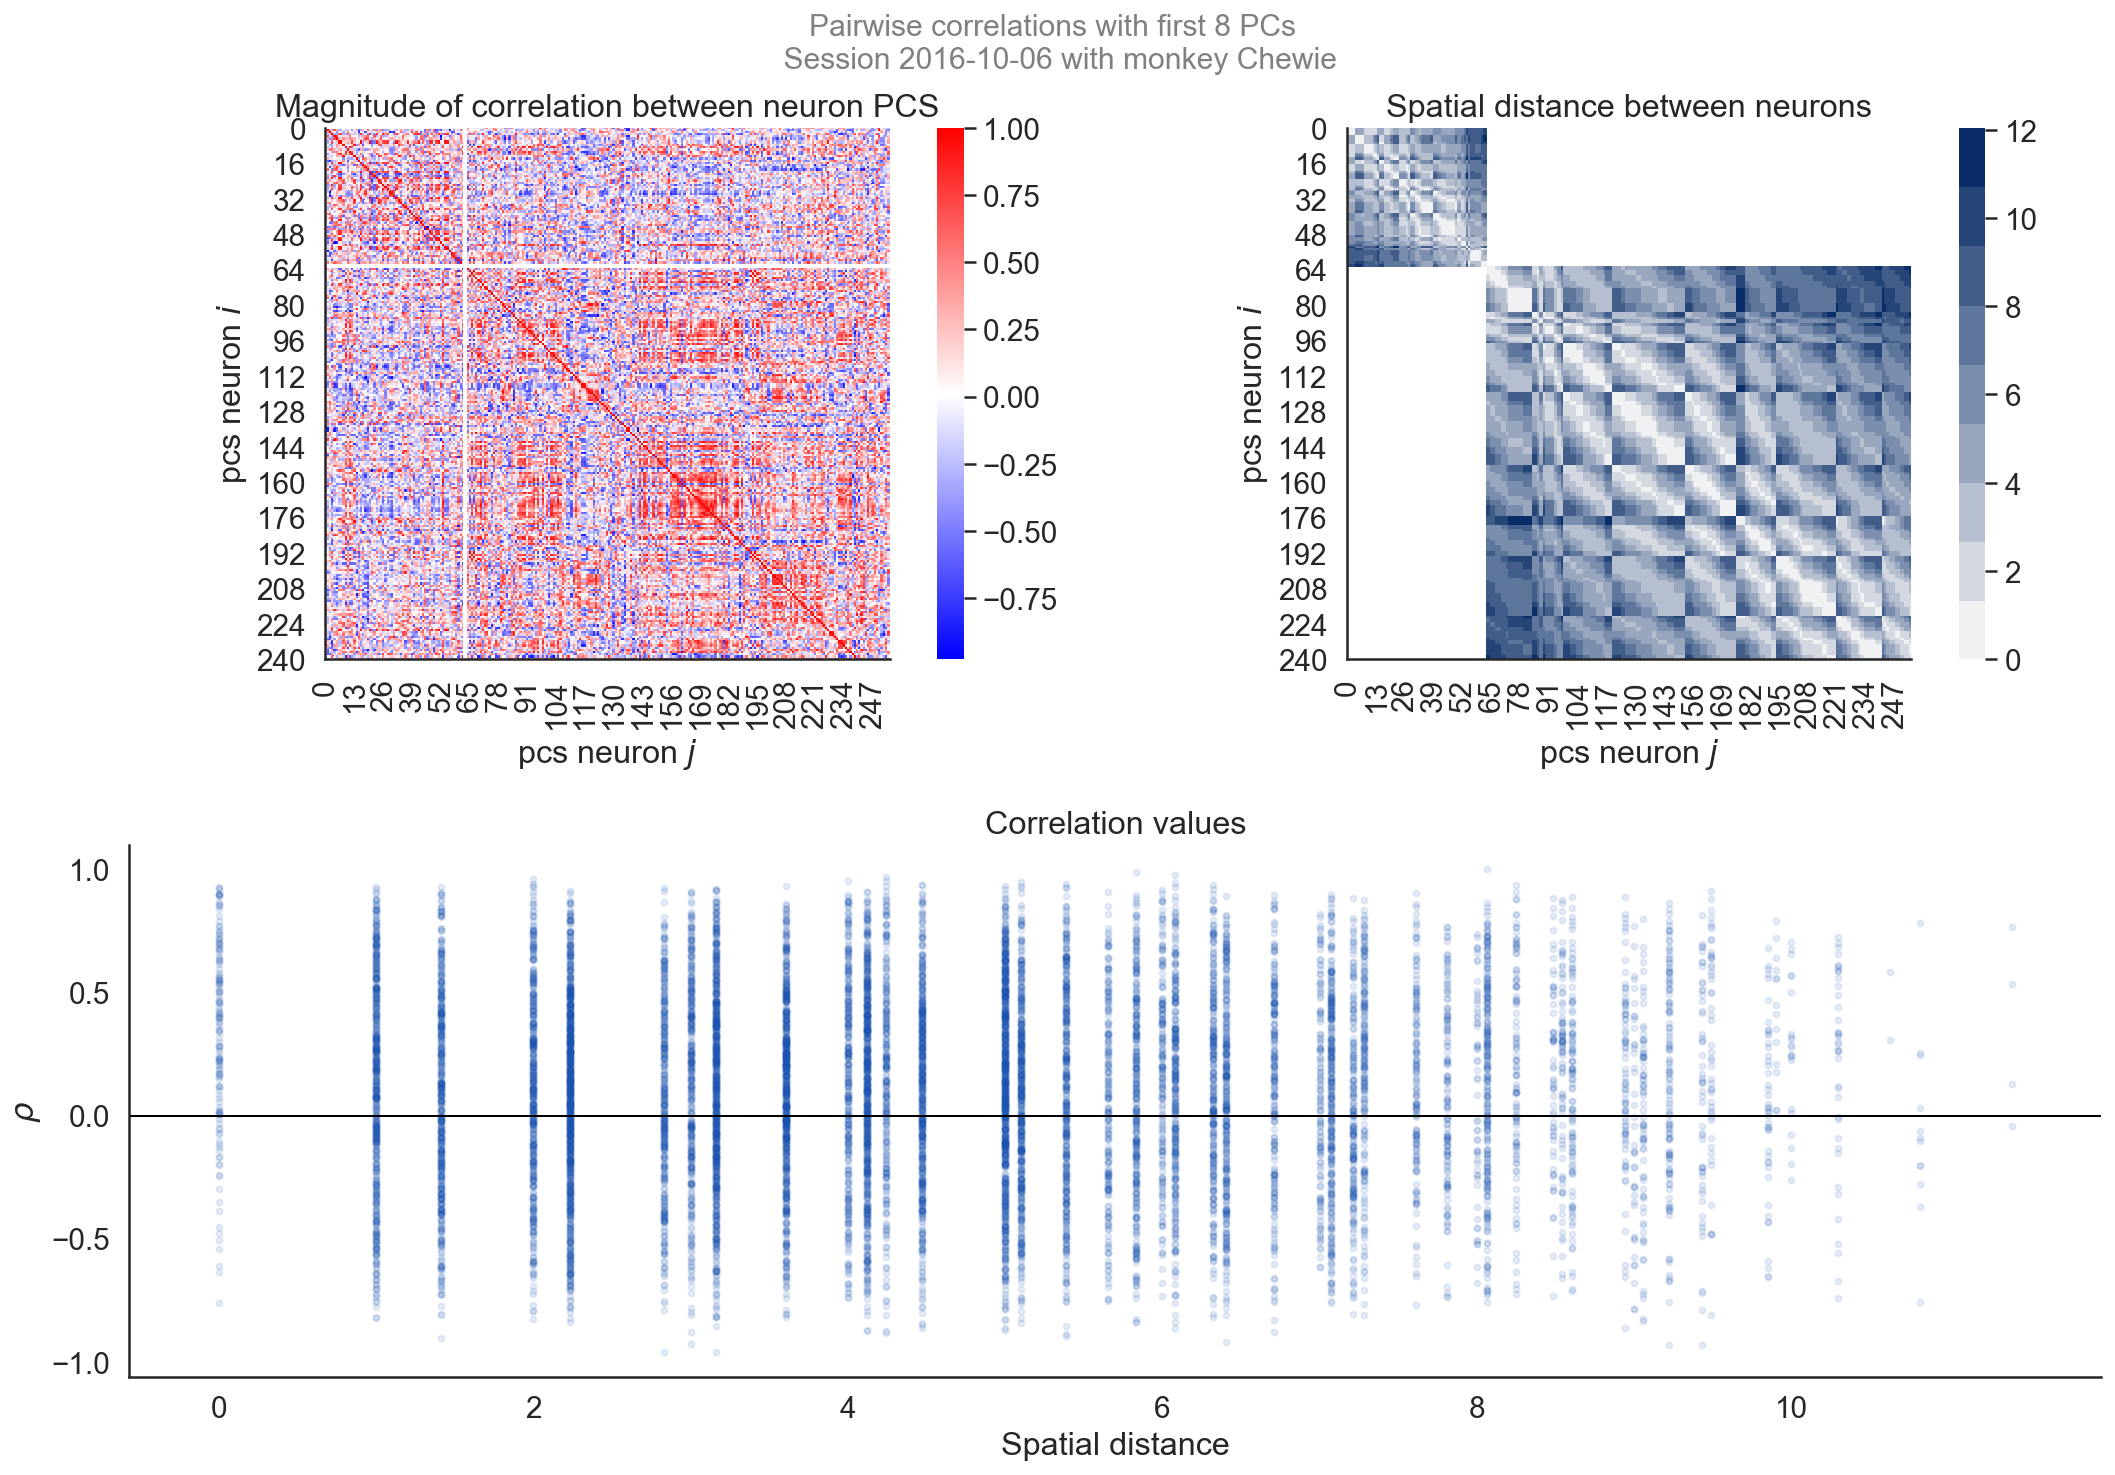

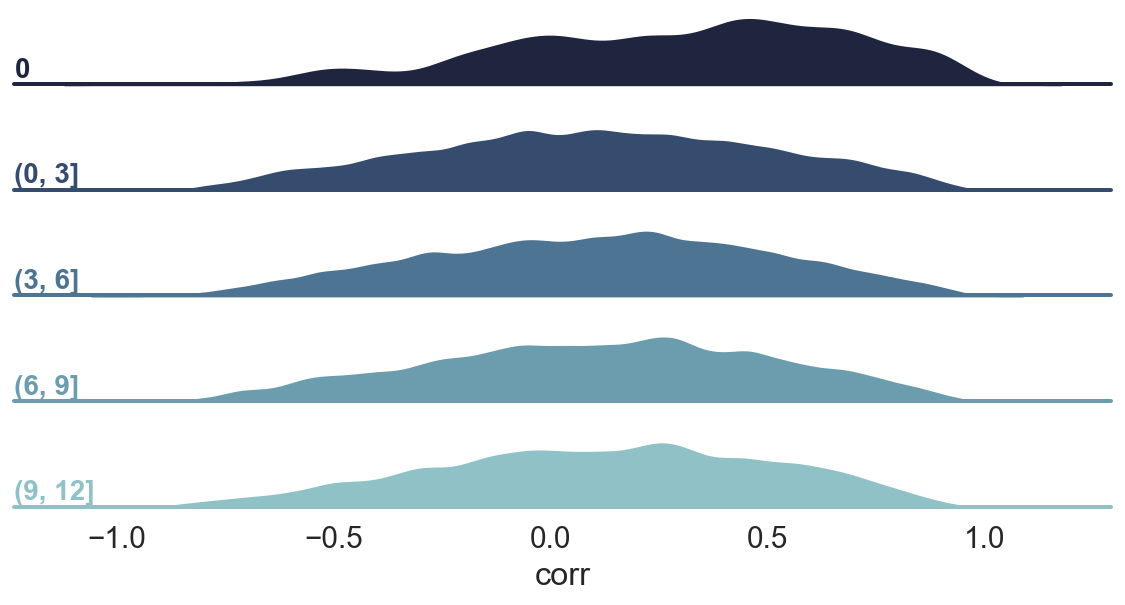

In [76]:
'''
Choose value for i and plot pairwise correlations
'''

df = pairwise_corr_plot(corr_arr=R_emp_arr, spatial_dist_arr=SD, i=5, r_range=r_range, 
                   td=td, date=date, monkey=monkey)

## Significance testing

### ANOVA

In [116]:
df

,corr,spatial dist,cat
0,0.688882,0.00000,0
1,-0.033503,0.00000,0
2,-0.137707,0.00000,0
3,0.671093,5.09902,"(3, 6]"
4,0.575713,5.09902,"(3, 6]"
...,...,...,...
32380,0.101984,1.00000,"(0, 3]"
32381,-0.277325,2.00000,"(0, 3]"
32382,0.538950,0.00000,0
32383,-0.598518,1.00000,"(0, 3]"


In [99]:
cat_0 = df.loc[df.cat == '0']['corr'].values
cat_3 = df.loc[df.cat == '(0, 3]']['corr'].values
cat_6 = df.loc[df.cat == '(3, 6]']['corr'].values
cat_9 = df.loc[df.cat == '(6, 9]']['corr'].values
cat_12 = df.loc[df.cat == '(9, 12]']['corr'].values

In [92]:
from scipy.stats import f_oneway

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

- There is one nominal variable (the category)
- and one measurement variable (the correlations)


[source](http://www.biostathandbook.com/onewayanova.html)

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

- The samples are independent. (valid)

- Each sample is from a normally distributed population. (perhaps invalid)

- The population standard deviations of the groups are all equal. This property is known as homoscedasticity. (perhaps invalid)

In [103]:
f_oneway(cat_0, cat_3, cat_6, cat_9, cat_12)

F_onewayResult(statistic=12.897586074876138, pvalue=1.7318729754810182e-10)

This implies that there is a significant variation in mean correlation among these 5 groups based on spatial distance.

The next step is to use the Tukey-Kramer test to see which pairs categories are significantly different in means.

In [117]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(df['corr'].values, df['cat'].values))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 (0, 3]  (3, 6]   0.0037    0.9 -0.0163 0.0236  False
 (0, 3]  (6, 9]   0.0091 0.7533 -0.0125 0.0306  False
 (0, 3] (9, 12]   0.0134 0.8024  -0.021 0.0478  False
 (0, 3]       0    0.182  0.001  0.1119  0.252   True
 (3, 6]  (6, 9]   0.0054    0.9 -0.0129 0.0238  False
 (3, 6] (9, 12]   0.0097    0.9 -0.0228 0.0422  False
 (3, 6]       0   0.1783  0.001  0.1092 0.2474   True
 (6, 9] (9, 12]   0.0043    0.9 -0.0292 0.0378  False
 (6, 9]       0   0.1729  0.001  0.1033 0.2424   True
(9, 12]       0   0.1686  0.001   0.094 0.2431   True
-----------------------------------------------------


- The usual way to graph the results of a one-way anova is with a bar graph. The heights of the bars indicate the means, and there's usually some kind of error bar, either 95% confidence intervals or standard errors. 

- How to do this for multiple PCs?


### Rank sum test

### Browse maps


In [60]:
browse_maps(R_emp_arr, R_gen_arr, td, r_range, abs_val=False)

interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<!-- ## On comparing principal components

How can we find out whether neighbouring neurons have more similar spike patterns then neurons that are further away? One way to look at this by reducing the data through some type of dimensionality reduction - PCA -, and then investigate the principal component weights.

The neural modes, in this case the principal components, can be seen as a generative model for the spiking patterns [_Neural manifolds for the control of movement_; Gallego, Perich, Miller, Solla; 2017]

<img src="https://drive.google.com/uc?export=view&id=1bnClVjyvMopJFa4AEMZg4rOPhTP2MToD" style="width: 500px; max-width: 100%; height: auto"/>


<img src="https://drive.google.com/uc?export=view&id=1q6X9JoagF_H6uKGcjxgZ7aCoJjBBCrqT" style="width: 500px; max-width: 100%; height: auto"/>


<img src="https://drive.google.com/uc?export=view&id=1vPFKUDWw9L73X5QFepUXtLKgCspf6QKB" style="width: 500px; max-width: 100%; height: auto"/>


So, one way of looking at differences is to take the absolute distance between the weight of each pair of neurons, as in the example above. In pseudocode this is something along the lines of 

```Python
pc = the kth principal component 

for i in neurons:
    
    find location of neuron i on array
    
    for j in neurons: # i != j 
        
        find location of neuron j on array

        spatial_distance = diff(location i, location j)
        weight_distance = abs(pc[i], pc[j])    
```

which yields a weight difference distribution for each principal component. While this gives some insight into the differences, it is also tricky to interpret, since we have a distribution for each neuron ($\times$ 200 neurons $\times$ a number of sessions). Here, we look at different ways metrics to gain insight into the relationship between PC weights and spatial distance in the brain.   -->

### 3.2 Correct for the increasing number of dimensions


> As _r_ increases, the number of dimensions over which the norm is computed increases $\to$ distributions become wider.


The $\ell_2$-norm of a vector $\mathbf{w} \in \mathbb{R}^n$ is given by
\begin{align*}
    \sqrt{\sum_{i=1}^n w_{i}^{2}}.
\end{align*}
We want to compare the $\ell_2$-norms of vectors of different lengths. Without loss of generality, we may assume the vectors are given by $\mathbf{w} \in \mathbb{R}^n$ and $v\in\mathbb{R}^m$ for $n \neq m$. Dividing the sum in the distances by $\sqrt{n}$ to yields:
\begin{align*}
    \sqrt{\frac{1}{n}\sum_{i=1}^n w_{i}^{2}}.
\end{align*}
which converts all the distances to the same scale (normalized x-axis).

In [34]:
for r in np.arange(100, 150, 3):
    
    # Compute the spatial and weight distances with the first r PCs
    S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                            pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
    # Make groups within array based on spatial distance (same elec, same array)
    _ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)
    
    # Make distribution
    standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r, dividesqrt=True)

old code

---

### Sanity check: combinatorics

The number of possible combinations (order is irrelevant) of $r=2$ neurons from a group of $n$ neurons on an array is
\begin{align}
    C_{(n, r)} = \frac{n!}{r! (n - r)!}
\end{align}
which is gives, for the M1 array$^*$, 
\begin{align}
    C_{(55, 2)} = \frac{55!}{2! (55 - 2)!} = 1485 
\end{align}
combinations and for the PMd array,
\begin{align}
    C_{(191, 2)} = \frac{191!}{2! (191 - 2)!} = 18145
\end{align}
combinations.

---

$^*$_Note that this is an example for one session. Other sessions have a different distribution of neurons per array._


### 3.3 Take one neuron and compare to all other neurons

How can we observe what happens to the weight differences as we incease _r_?

One thing to do is to choose one neuron and plot the weight distance over _r_.



<img src="https://drive.google.com/uc?export=view&id=1GtMqpmWOK3s2EXSDScLrSVJvcTA6Baqk" style="width: 500px; max-width: 100%; height: auto"/>



In [ ]:
# for neuron in np.arange(0, 10, 2):
    
#     compare_one_to_all(pcs=m1pmd_pcs, emap=m1_elecmap, unitguide=td.M1_unit_guide[0], n_arr=td.M1_unit_guide[0].shape[0], i=neuron)


### 3.4 Use the spatial distance to sort the weight distances of _r_ PCs

One way to find out whether there is a relationship between physical location and distance in the principal component ways is to compute the weight distances with _r_ PCs and then sort them based on spatial distance. 

> Edit: this does not seem to do a lot. Skipping this step for now.

In [1]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
axs[0].set_title(f'Weight distances with first {r} PCs | same electrode')
axs[0].stem(W_dist_se, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[0].set_ylim([0, 1])

axs[1].set_title(f'Weight distances with first {r} PCs | same array')
axs[1].stem(W_dist_sa, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[1].set_ylim([0, 1])

axs[2].set_title(f'Weight distances with first {r} PCs | other array')
axs[2].stem(W_dist_oa, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[2].set_ylim([0, 1])

sns.despine(), plt.tight_layout();


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
axs[0].set_title('Weight distances same electrode')
axs[0].hist(W_dist_se, color=cs[0])
axs[0].set_xlim([0, 1])

axs[1].set_title('Weight distances same array')
axs[1].hist(W_dist_sa, color=cs[1])
axs[1].set_xlim([0, 1])

axs[2].set_title('Weight distances other array')
axs[2].hist(W_dist_oa, color=cs[2])
axs[2].set_xlim([0, 1])
sns.despine(), plt.tight_layout();

NameError: name 'plt' is not defined